In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random

In [2]:
G = nx.read_weighted_edgelist("Contact-diaries-network_data_2013.csv", nodetype=int)

In [3]:
color_map=['blue' for number in range(len(G.nodes()))]

In [4]:
color_map[109] = 'red'

In [5]:
opt = { 'node_color': color_map,
        'node_size': 50,
        'width': 1,
        'with_labels': False,
        'font_weight': 'bold'}

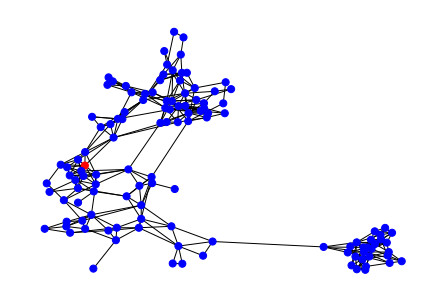

In [6]:
nx.draw(G, **opt)

Esta función sirve para "abrir" aristas después de un tiempo agendado de apertura. Se toma el mayor de los tiempos agendados para abrir la arista. 

In [7]:
def open_edge(event, H):
    #event is (0: time, 1: edge, 2:type)
    if H.edges[event[1]]['sched_reopen'] > event[0]:
        return(1)
    else:
        H.edges[event[1]]['status'] = 'open'

Función de recuperación de los nodos, que toma un nodo y cambia su estado a "recuperado". Se abre el contacto con todos los vecinos del nodo que tienen un estado distinto de infectado.

In [8]:
def process_recovery(event, H, times, S, I, R): 
    #events are (0: time, 1: node, 2: type)

    H.nodes[event[1]]['status'] = 'recovered'
    times.append(event[0])
    S.append(S[-1])
    I.append(I[-1]-1)
    R.append(R[-1]+1)
    
    for nb in H.neighbors(event[1]):
        if H.nodes[nb]['status'] != 'infected':
            H[nb][event[1]]['state'] = 'open'

Función de transmisión, toma al nodo y cambia su estado de susceptible a infectado. Se toma una fracción de sus vecinos y se cierran los contactos entre ellos.

In [9]:
def process_transmission(event,H, times, S, I, R, list_of_events, beta, gamma, Tmax): 
    
    #beta contagion rate or infection rate or transmission rate
    #gamma recovery rate
    #beta_fm rate or infection rate of people that use facemask, is less than beta.
    
    #events are (0: time, 1: node, 2: type)
    if H.nodes[event[1]]['status'] == 'susceptible':

        H.nodes[event[1]]['status'] = 'infected'

        times.append(event[0])
        S.append(S[-1]-1)
        I.append(I[-1]+1)
        R.append(R[-1])
        
        to_close = round(H.nodes[event[1]]['isolation']*H.degree(event[1]))
        
        edges_to_close = random.sample(list(H.edges(event[1])), to_close)
        
        #nuevo
        for edge in edges_to_close:
            H.edges[edge]['state'] = 'close'
            t = event[0]+random.expovariate(1)
            if t > H.edges[edge]['sched_reopen']:
                H.edges[edge]['sched_reopen'] = t
                reopen_edge = (t, edge, 'open') 
                list_of_events.append(reopen_edge)
                list_of_events.sort()

        rec_time = event[0] + random.expovariate(gamma)

        if rec_time < Tmax:
            new_event = (rec_time, event[1], 'recovery')
            list_of_events.append(new_event)
            list_of_events.sort()

        for target in H.neighbors(event[1]):
            if H.nodes[target]['status'] == 'susceptible' and H[target][event[1]]['state'] == 'open':
                inf_time = event[0] + random.expovariate(beta)
         

                if inf_time < min(rec_time, H.nodes[target]['pred_inf_time'], Tmax):
                    new_event = (inf_time, target, 'transmit')
                    list_of_events.append(new_event)
                    list_of_events.sort()
                    H.nodes[target]['pred_inf_time'] = inf_time            

In [14]:
def epidemic(H,beta,gamma,Tmax,isolation):
    if(nx.is_connected(H)==False):
        raise ValueError("Graph H must be connected")
    
    list_of_events = []
    times, S, I, R = [0], [len(H.nodes)], [0], [0]
    
    for e in H.edges:
        H.edges[e]['state'] = 'open'
        H.edges[e]['sched_reopen'] = 0
        
    

    
    for u in H.nodes:
        H.nodes[u]['status'] = 'susceptible'
        H.nodes[u]['pred_inf_time'] = np.inf
        #H.nodes[u]['isolation'] = random.random()
        x=random.random()
        if x<.516:
            H.nodes[u]['isolation'] = isolation[0]
        elif x < .662:
            H.nodes[u]['isolation'] = isolation[1]
        elif x < .908:
            H.nodes[u]['isolation'] = isolation[2]
        else:
            H.nodes[u]['isolation'] = isolation[3]

    
    u = np.random.choice(H.nodes, size=1)[0]

    H.nodes[u]['pred_inf_time'] = 0

    #events are (time, node, type)
    event = (0, u, 'transmit')

    list_of_events.append(event)
    list_of_events.sort()
    
    while(len(list_of_events) > 0):
        event = list_of_events.pop(0)
    
        if event[2] == 'transmit':
            process_transmission(event,H, times, S, I, R, list_of_events, beta, gamma, Tmax)
        elif event[2] == 'open':
            open_edge(event, H)
        else:
            process_recovery(event,H, times, S, I, R)
    
    network_data = np.column_stack((times, S, I, R))
    return(network_data)

In [15]:
epidemic(G,1.5,1,50,[0.4,0.7,0.6,0.8])

array([[  0.        , 120.        ,   0.        ,   0.        ],
       [  0.        , 119.        ,   1.        ,   0.        ],
       [  0.19179386, 118.        ,   2.        ,   0.        ],
       [  0.23967106, 117.        ,   3.        ,   0.        ],
       [  0.61697849, 116.        ,   4.        ,   0.        ],
       [  0.65307963, 115.        ,   5.        ,   0.        ],
       [  0.7175179 , 115.        ,   4.        ,   1.        ],
       [  0.75799181, 114.        ,   5.        ,   1.        ],
       [  0.76061862, 113.        ,   6.        ,   1.        ],
       [  0.7646155 , 112.        ,   7.        ,   1.        ],
       [  0.76574082, 111.        ,   8.        ,   1.        ],
       [  0.77511981, 110.        ,   9.        ,   1.        ],
       [  0.82081578, 110.        ,   8.        ,   2.        ],
       [  0.89402321, 110.        ,   7.        ,   3.        ],
       [  0.91775173, 109.        ,   8.        ,   3.        ],
       [  0.93768247, 109

In [21]:
m=1
for isolation in ([0,0.1,0.5,0.9], [0.05,0.1,0.5,0.9], [0.1,0.1,0.5,0.9], [0.15,0.1,0.5,0.9], [0.2,0.1,0.5,0.9], [0.25,0.1,0.5,0.9], [0.3,0.1,0.5,0.9], 
                  [0.35,0.1,0.5,0.9], [0.4,0.1,0.5,0.9], [0.45,0.1,0.5,0.9], [0.5,0.1,0.5,0.9]):
    l=[]
    for i in range(5000):
        l.append(epidemic(G,1.5,1,50,isolation)[-1][-1])
    arr = np.array(l)
    txt = 'isolation_' + format(m) + '.csv'
    np.savetxt(txt,arr,delimiter=",")
    m = m + 1